### Statistical and Grid Network Package

In [54]:
import os
import numpy as np
import networkx as nx
import pandas as pd
import torch
import copy

#Pandapower Package
import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
import pandapower.diagnostic as diagnostic

from pandapower.powerflow import LoadflowNotConverged
from pandapower.diagnostic import diagnostic
from pandapower.control import ConstControl
from pandapower.timeseries import DFData, OutputWriter, run_timeseries
from pandapower.pypower.makeYbus import makeYbus

import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.linalg
import scipy.sparse as sp
from scipy.stats import gaussian_kde
from itertools import product
from tqdm import tqdm
import seaborn as sns

## Causal Discovery and Causal Inference Package

In [55]:
import causallearn
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.cit import fisherz
from causallearn.search.ScoreBased.GES import ges
from causallearn.score.LocalScoreFunction import local_score_BIC
from causallearn.search.FCMBased.PNL.PNL import PNL

from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
from dowhy import gcm # Graphical Causal Models 
from lingam import DirectLiNGAM
from scipy.special import psi

import warnings
from sklearn.exceptions import ConvergenceWarning  

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Load the Collected data

In [56]:
# 10000 Scenarios case

# file_path =r'C:\Users\jliu359\Downloads\Causal_reliability_Contingnecy_case3_10000_519.xlsx'  #Lab PC

file_path =r'C:\Users\jliu359\Downloads\Causal_Reliability_Contingnecy_case3_10000_527_p50.xlsx'

#file_path =r'C:\Users\jliu359\Downloads\Causal_reliability_Contingnecy_case4_10000_519.xlsx' #case4

# 2000 scenarios case

#file_path = r'C:\Users\jliu359\Downloads\Causal_reliability_Results_contingnecy_case3.xlsx' #lab PC

# file_path = r'C:\Users\default.DESKTOP-C4C7JDR\Downloads\Causal_reliability_Results_contingnecy_case3.xlsx' # Home PC

df = pd.read_excel(file_path)
print(df.head())

   Scenario  Sgen1_Mean_Solar Output  Sgen2_Mean_Solar Output  \
0         1                10.294612                14.036775   
1         2                11.399754                12.153471   
2         3                 9.289701                 8.499261   
3         4                12.308779                12.098492   
4         5                11.279655                13.304648   

   Sgen3_Mean_Solar Output  Sgen4_Mean_Solar Output  Sgen5_Mean_Solar Output  \
0                13.537064                11.836890                 8.446096   
1                 7.749541                10.978383                12.891740   
2                 9.498811                12.075848                 6.691267   
3                 6.368931                 8.206568                 8.999810   
4                11.578808                13.313441                13.869457   

   Sgen6_Mean_Solar Output  Sgen7_Mean_Solar Output  Sgen8_Mean_Solar Output  \
0                 8.439551                 6.750

### Preprocess Features with the collected dataset

In [57]:
# Drop non-numeric columns "Scenario" and "Contingency"
df = df.drop(columns=["Scenario", "Contingency"])

#Check and replace the NAN value
print("Original data NaN check:")
print(df.isnull().sum().sort_values(ascending=False).head())
df = df.fillna(df.mean())

# Drop constant columns (zero variance)
df = df.loc[:, df.apply(pd.Series.nunique) > 2]

#Optimize the dataset features, Drop all voltage angle features (usually ends with '_va_degree')
angle_cols = [col for col in df.columns if 'va_degree' in col.lower()]
df = df.drop(columns=angle_cols)

#Normalize the Data 
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# Normalization for Avoids the scale bias

# Adds a very small random noise to the all numerical columns 

# Why add the mini noiese :In causal discovery algorithms like PC or GES (especially when using statistical tests like FisherZ),
# Need to compute matrix inverses (e.g., inverse of a covariance or correlation matrix).

# If two or more variables are perfectly correlated (or almost perfectly), the covariance matrix becomes singular (non-invertible), leading to an error

df_scaled += np.random.normal(scale=1e-6, size=df_scaled.shape)

# Final NaN check 
assert not df_scaled.isnull().any().any(), "There are still NaN values in the scaled data!"

Original data NaN check:
Bus12_Mean_va_degree    2
Bus12_Mean_vm_pu        2
Bus4_Mean_va_degree     0
Bus5_Mean_va_degree     0
Bus20_Mean_va_degree    0
dtype: int64


In [58]:
for i, name in enumerate(df_scaled.columns):
    print(f"{i}: {name}")

0: Sgen1_Mean_Solar Output
1: Sgen2_Mean_Solar Output
2: Sgen3_Mean_Solar Output
3: Sgen4_Mean_Solar Output
4: Sgen5_Mean_Solar Output
5: Sgen6_Mean_Solar Output
6: Sgen7_Mean_Solar Output
7: Sgen8_Mean_Solar Output
8: Bus2_Mean_vm_pu
9: Bus3_Mean_vm_pu
10: Bus4_Mean_vm_pu
11: Bus5_Mean_vm_pu
12: Bus6_Mean_vm_pu
13: Bus7_Mean_vm_pu
14: Bus8_Mean_vm_pu
15: Bus9_Mean_vm_pu
16: Bus10_Mean_vm_pu
17: Bus11_Mean_vm_pu
18: Bus12_Mean_vm_pu
19: Bus13_Mean_vm_pu
20: Bus14_Mean_vm_pu
21: Bus15_Mean_vm_pu
22: Bus16_Mean_vm_pu
23: Bus17_Mean_vm_pu
24: Bus18_Mean_vm_pu
25: Bus19_Mean_vm_pu
26: Bus20_Mean_vm_pu
27: Bus21_Mean_vm_pu
28: Bus22_Mean_vm_pu
29: Bus23_Mean_vm_pu
30: Bus24_Mean_vm_pu
31: Bus25_Mean_vm_pu
32: Bus26_Mean_vm_pu
33: Bus27_Mean_vm_pu
34: Bus28_Mean_vm_pu
35: Bus29_Mean_vm_pu
36: Shortest Gen-to-Gen Impedance
37: Longest Gen-to-Gen Impedance
38: Shortest Load-to-Load Impedance
39: Longest Load-to-Load Impedance
40: Shortest Gen-to-Load Impedance
41: Longest Gen-to-Load Impedance

## Apply Different Causal Discovery Methods to Build  the Causal Graph

### Peter-Clark (PC) Algorithm

In [59]:
# Peter-clark (PC) Algorithm with Fisher's Z-test for conditional independence
cg_pc = pc(data=df_scaled.values, independence_test_method="fisherz", alpha=0.05)

def cg_to_nx_directed(cg, ignore_bidirected=True):
    """
    Convert a CausalGraph object (from causal-learn) to a NetworkX DiGraph.

    Parameters:
        cg: CausalGraph object
        ignore_bidirected: if True, skip edges where both directions are 1 (i.e., bidirected edges) assume no latent confounders in this study case

    Returns:
        G: networkx.DiGraph
    """
    G = nx.DiGraph()
    graph = cg.G.graph
    d = graph.shape[0]

    for i in range(d):
        for j in range(i + 1, d):  # avoid redundant checks
            a, b = graph[i, j], graph[j, i]

            if a == -1 and b == 1:
                G.add_edge(i, j)  # i → j
            elif a == 1 and b == -1:
                G.add_edge(j, i)  # j → i
            elif a == -1 and b == -1:
                G.add_edge(i, j)
                G.add_edge(j, i)  # i — j (undirected)
            elif a == 1 and b == 1 and not ignore_bidirected:
                G.add_edge(i, j)
                G.add_edge(j, i)  # i ↔ j (bidirected)
            # else: ignore if (1,1) and we assume no latent confounder

    return G
# Convert PC output to NetworkX graph
g_pc = cg_to_nx_directed(cg_pc)

  0%|          | 0/47 [00:00<?, ?it/s]

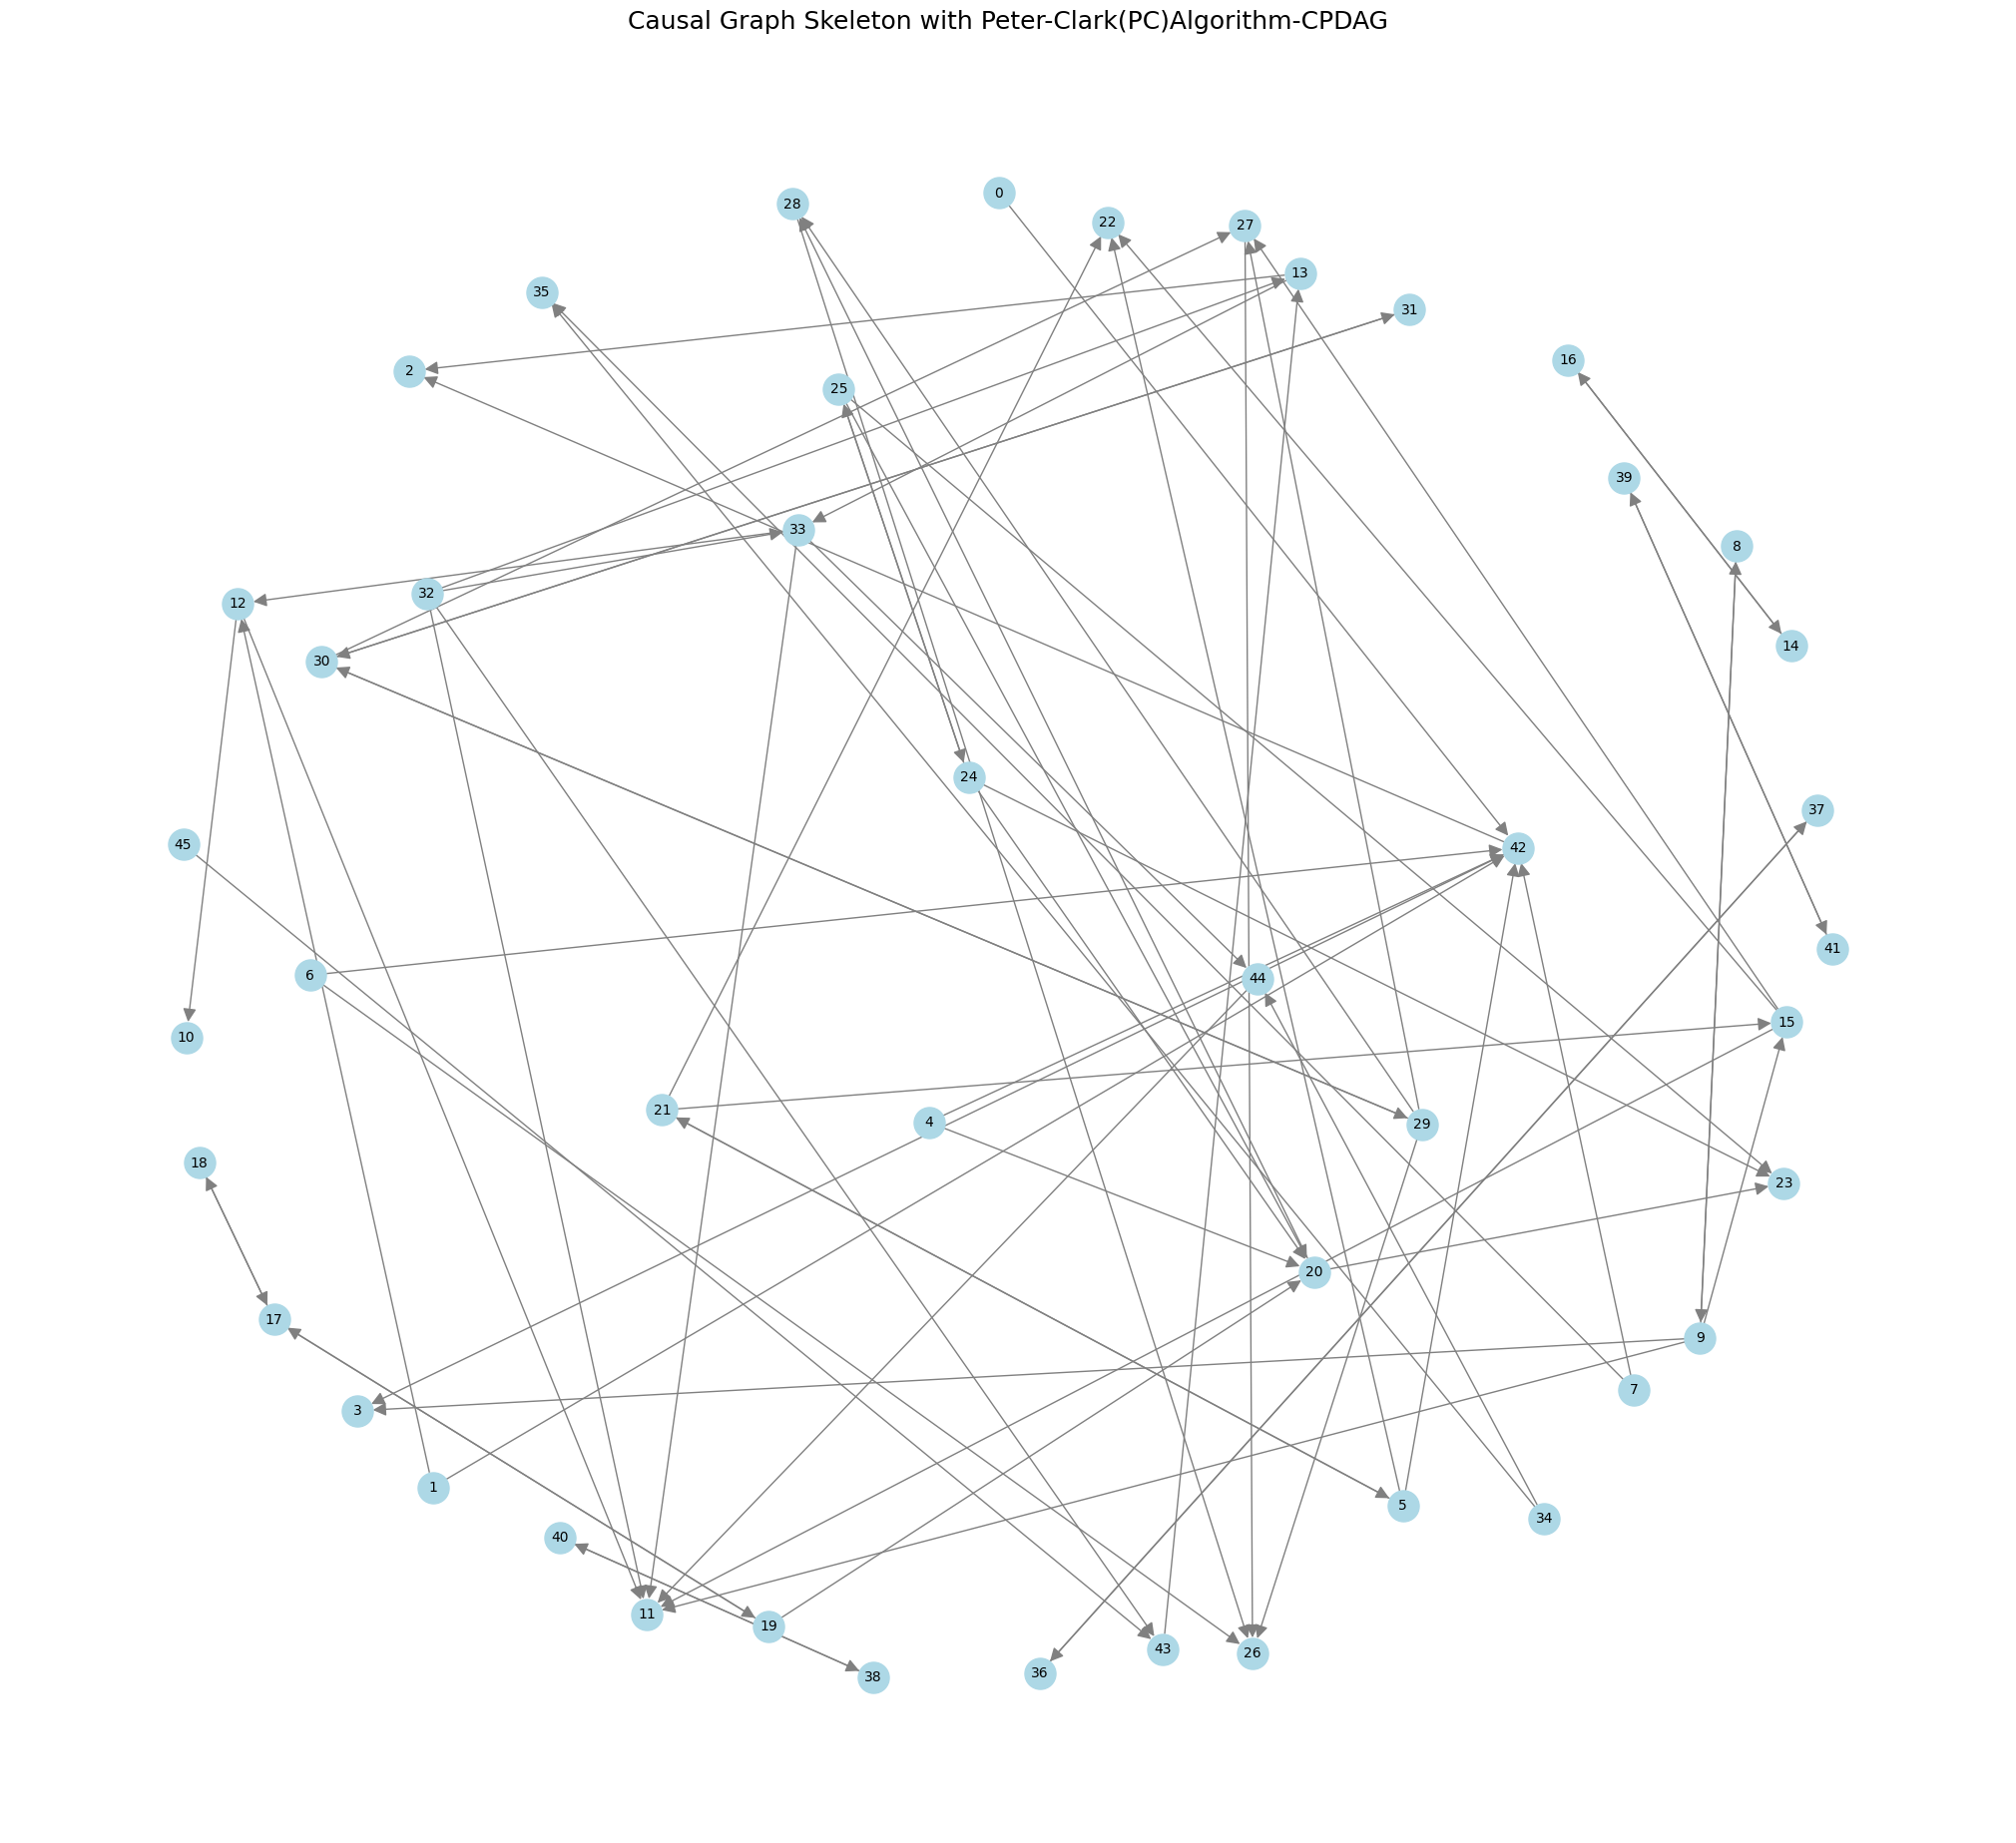

In [60]:
plt.figure(figsize=(20, 18))  
pos = nx.spring_layout(g_pc,k=3.0, seed=42,iterations=100)  

nx.draw(
    g_pc,
    pos,
    with_labels=True,
    node_color='lightblue',
    edge_color='gray',
    node_size=500,     
    font_size=10,      
    arrowsize=20     
)

plt.title("Causal Graph Skeleton with Peter-Clark(PC)Algorithm-CPDAG", fontsize=18)
plt.show()

### Post-Nonlinear (PNL) Causal Models to determine the causal Direction with P-value

###  PC+PNL Method to get the Causal Graph
Applies the PNL method only to those undirected edge pairs to determine the correct direction

In [61]:
def run_pnl_on_undirected(df, graph):
    pnl = PNL()
    cols = df.columns
    directed_updates = []
    checked_pairs = set()

    print("Resolving undirected edges with PNL...")

    # Identify undirected pairs (i—j means both i→j and j→i exist)
    for i, j in graph.edges():
        if (j, i) in graph.edges() and (j, i) not in checked_pairs and (i, j) not in checked_pairs:
            checked_pairs.add((i, j))

            x = df[[i]].values if i in df.columns else df.iloc[:, i].values.reshape(-1, 1)
            y = df[[j]].values if j in df.columns else df.iloc[:, j].values.reshape(-1, 1)

            try:
                p_x_to_y, p_y_to_x = pnl.cause_or_effect(x, y)

                # Only accept a direction if confidence (difference in p-values) is above threshold
                if abs(p_x_to_y - p_y_to_x) > 0.05:
                    if p_x_to_y > p_y_to_x:
                        directed_updates.append((i, j))  # x → y
                    else:
                        directed_updates.append((j, i))  # y → x
                else:
                    continue  # Skip uncertain edge

            except Exception as e:
                print(f"Error analyzing pair ({i}, {j}): {e}")

    # Remove all undirected  edges
    for (i, j) in checked_pairs:
        if graph.has_edge(i, j):
            graph.remove_edge(i, j)
        if graph.has_edge(j, i):
            graph.remove_edge(j, i)

    # Add confidently inferred directions
    for (src, tgt) in directed_updates:
        graph.add_edge(src, tgt)

    return graph

In [62]:
# Apply to resolve directions
g_refined = run_pnl_on_undirected(df_scaled, g_pc.copy())

Resolving undirected edges with PNL...


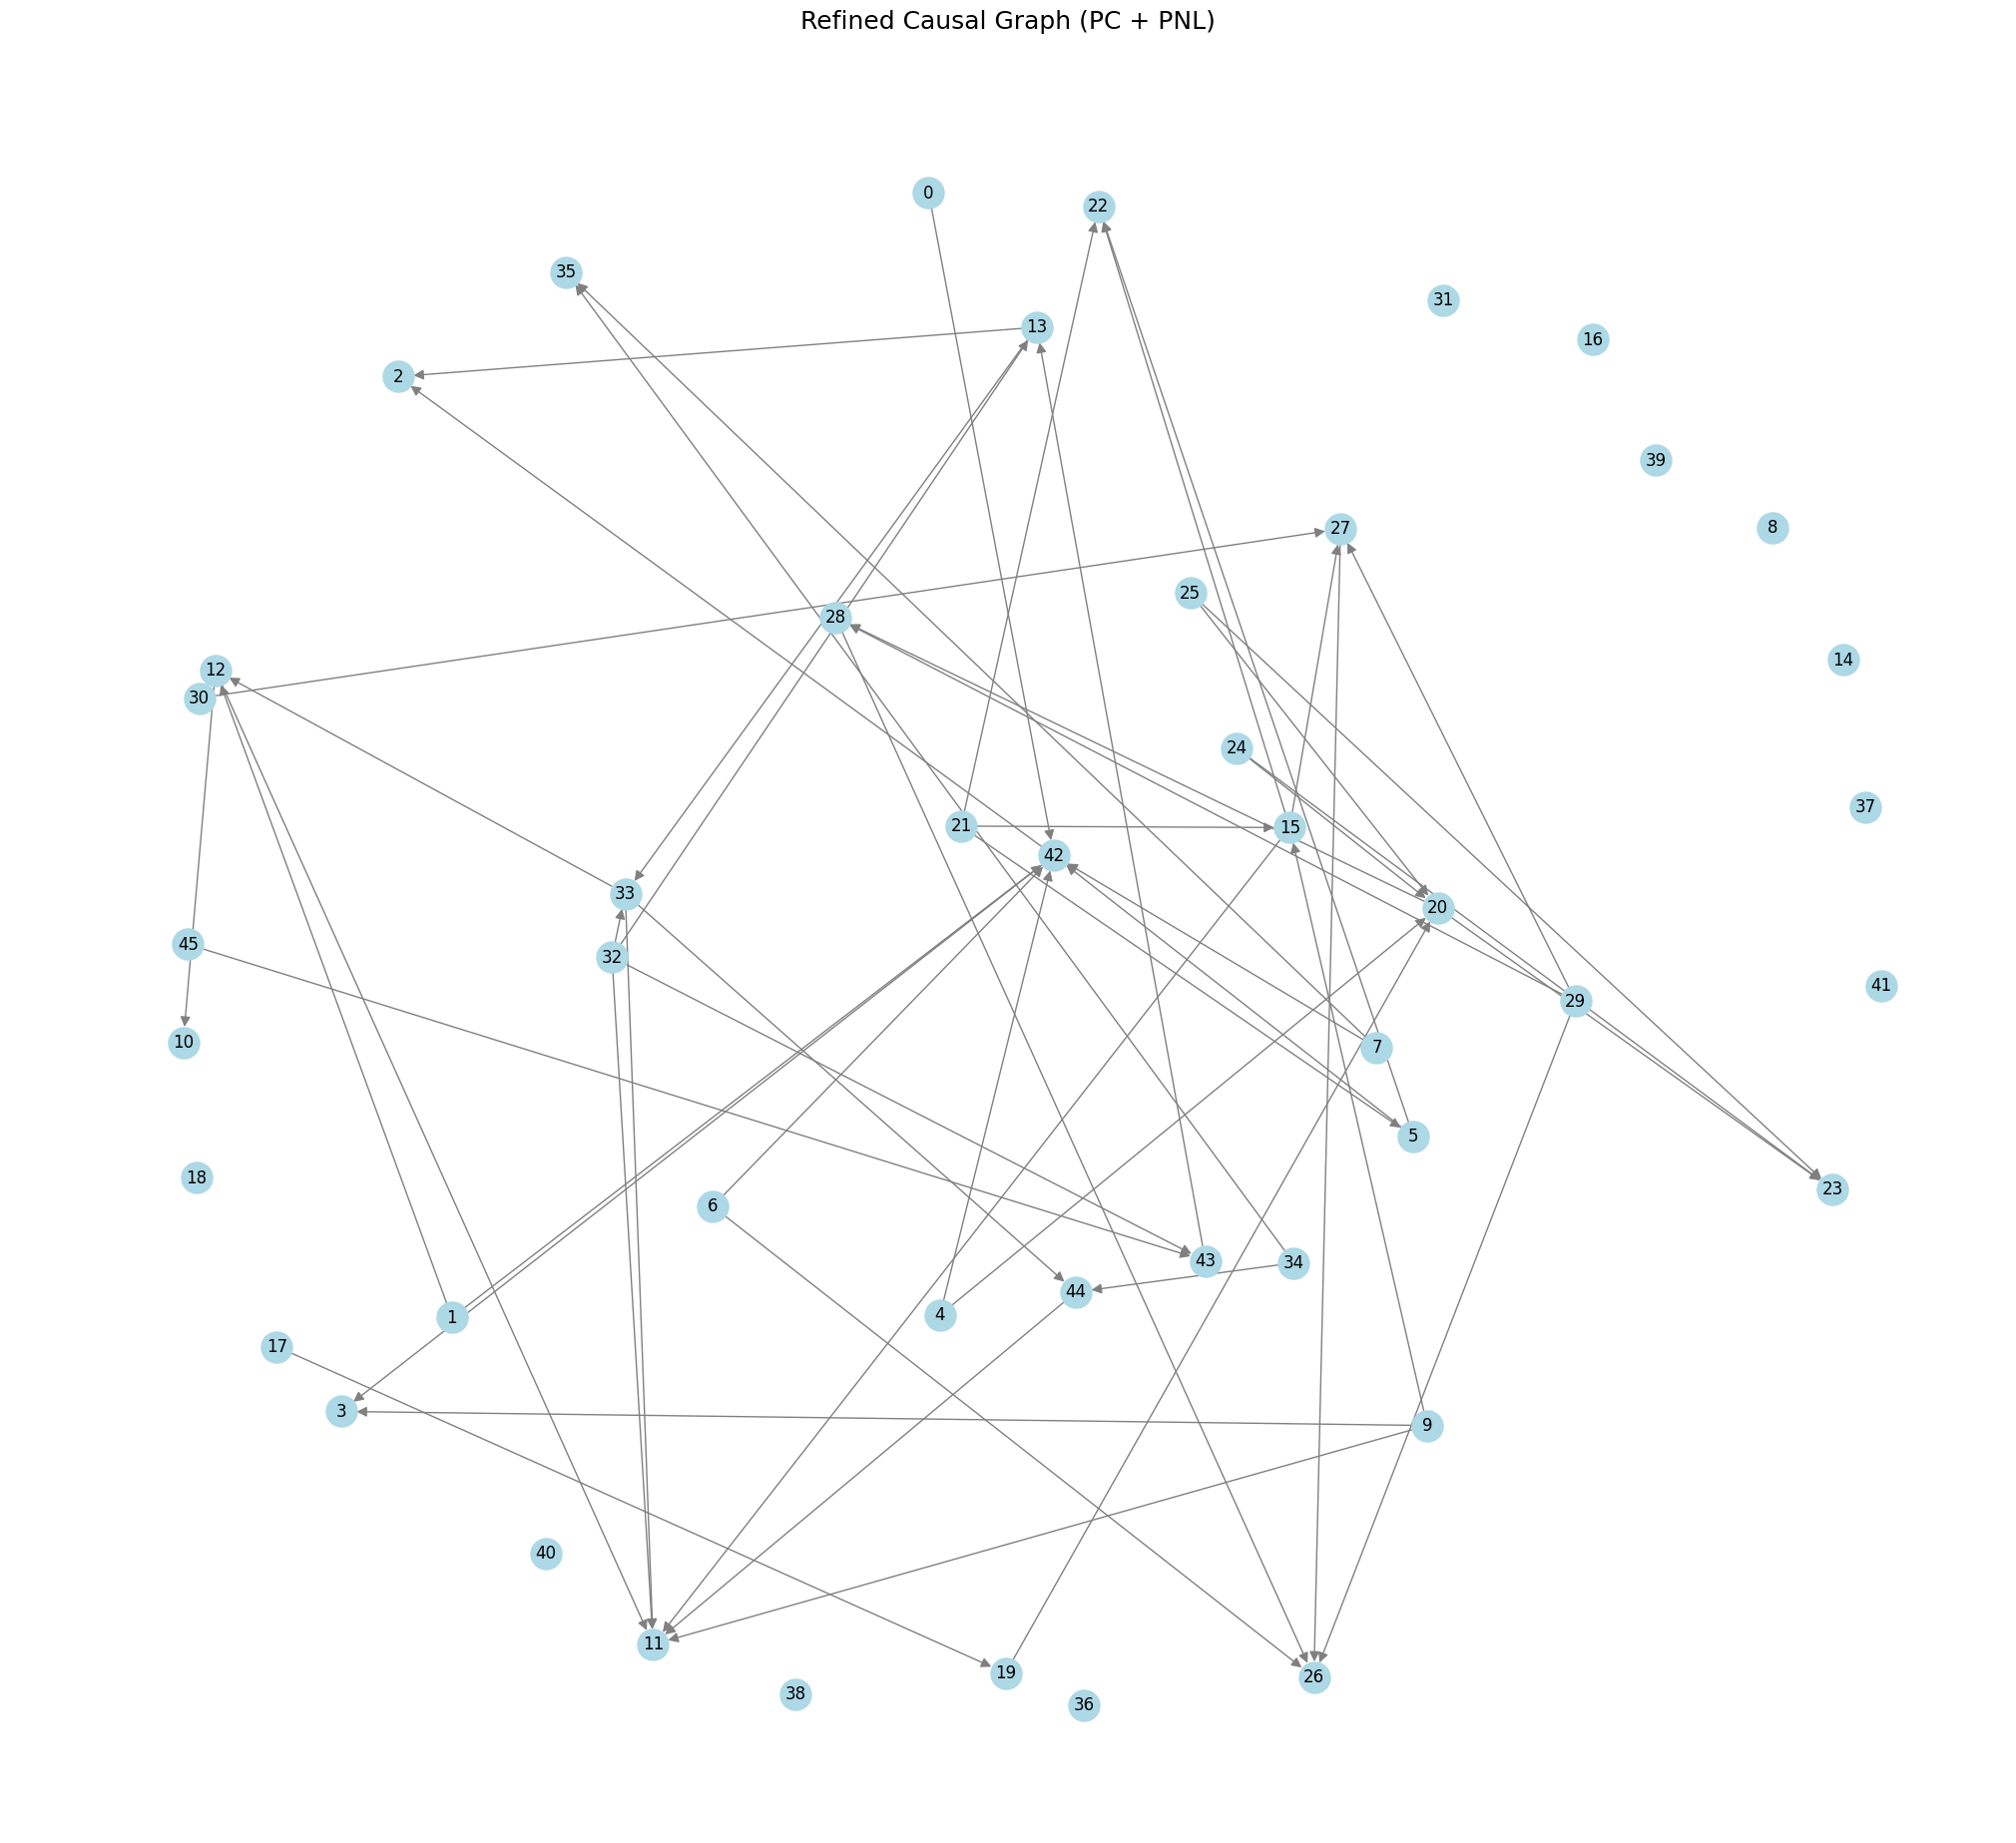

In [63]:
#Visualization
plt.figure(figsize=(20, 18))

# Set up the layout (positions of nodes)
pos = nx.spring_layout(g_refined, k=2.0, seed=42, iterations=100)

# Draw the graph
nx.draw(
    g_refined,
    pos,
    with_labels=True,
    node_color='lightblue',
    edge_color='gray',
    node_size=500,
    font_size=12,
    arrowsize=15
)

# Set title
plt.title("Refined Causal Graph (PC + PNL)", fontsize=18)

# Hide axis
plt.axis('off')

# Show plot
plt.show()

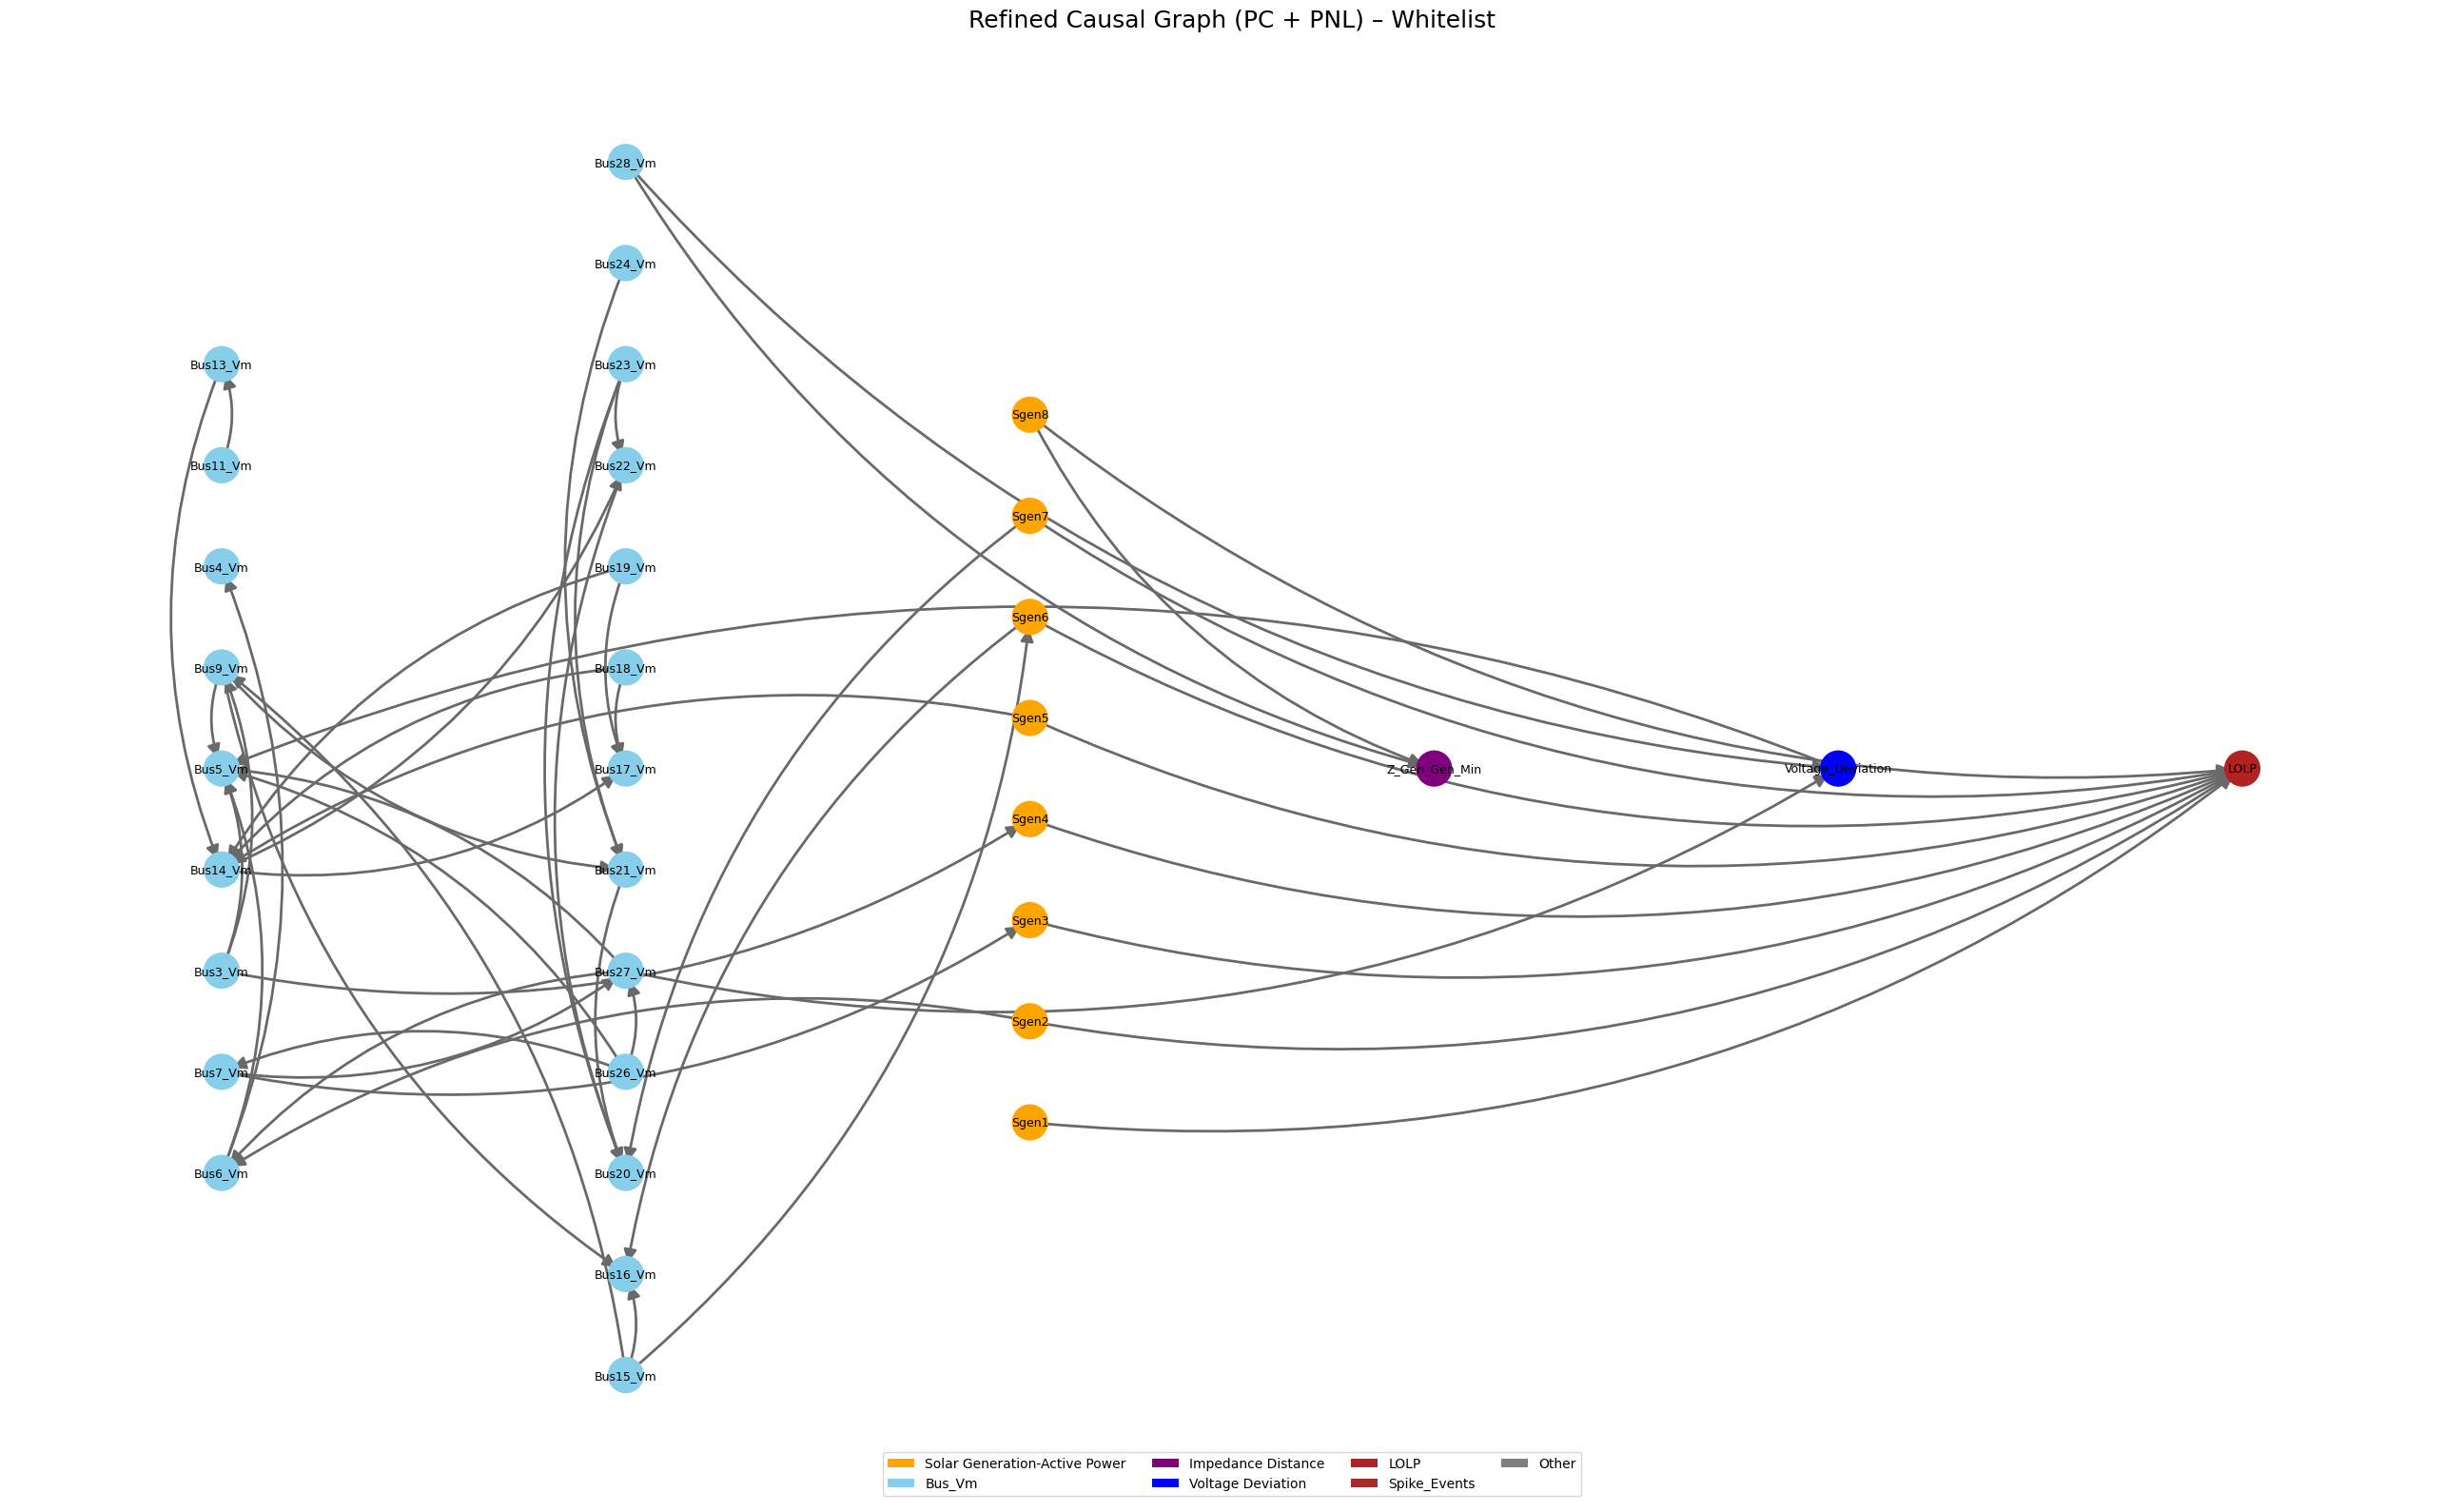

In [64]:
# Optimize the Built DAG Causal graph
## Such like Don't mix part-whole causality too freely:
# If Total_Gen = sum(Sgen1–Sgen8 + ConvGen), it is deterministically dependent, not causally
from matplotlib.patches import Patch
# === Remove isolated & 'Total_*' nodes ===
total_nodes = {41, 42, 43}  # Total_Solar, Total_Conv, Total_Gen
g_refined.remove_nodes_from(list(nx.isolates(g_refined)))
g_refined.remove_nodes_from([n for n in total_nodes if n in g_refined.nodes])

# ===Add edges from all Sgen nodes to LOLP manually ===
LOLP_node = 45
for sgen_node in range(0, 8):  # Sgen1 to Sgen8
    if g_refined.has_node(sgen_node) and g_refined.has_node(LOLP_node):
        g_refined.add_edge(sgen_node, LOLP_node)

# === Define colors by category ===
legend_labels = {
    'Solar Generation-Active Power': 'orange',
    'Bus_Vm': 'skyblue',
    'Impedance Distance': 'purple',
    'Voltage Deviation': 'blue',
    'LOLP': 'firebrick',
    'Spike_Events': 'brown',
    'Other': 'gray'
}

# === Assign node colors & layers ===
node_colors = []
node_layers = {}
for i in g_refined.nodes:
    if 0 <= i <= 7:
        node_colors.append(legend_labels['Solar Generation-Active Power'])
        node_layers[i] = 2
    elif 8 <= i <= 20:
        node_colors.append(legend_labels['Bus_Vm'])
        node_layers[i] = 0
    elif 21 <= i <= 34:
        node_colors.append(legend_labels['Bus_Vm'])
        node_layers[i] = 1
    elif 35 <= i <= 40:
        node_colors.append(legend_labels['Impedance Distance'])
        node_layers[i] = 3
    elif i == 44:
        node_colors.append(legend_labels['Voltage Deviation'])
        node_layers[i] = 4
    elif i in [45, 46]:
        color = legend_labels['LOLP'] if i == 45 else legend_labels['Spike_Events']
        node_colors.append(color)
        node_layers[i] = 5
    else:
        node_colors.append(legend_labels['Other'])
        node_layers[i] = 6

# === Group nodes by layer for layout ===
layer_nodes = {}
for node, layer in node_layers.items():
    layer_nodes.setdefault(layer, []).append(node)

pos = {}
for layer, nodes in sorted(layer_nodes.items()):
    x = layer * 5
    y_spacing = 2.0
    y_offset = -(len(nodes) - 1) / 2 * y_spacing
    for i, node in enumerate(nodes):
        pos[node] = (x, y_offset + i * y_spacing)

# === The electrical distances (like Z_Gen_Load_Min) may be nearly constant or collinear with other predictors (e.g., Bus_Vm), causing them to be conditionally independent of LOLP.Define readable labels ===
detailed_labels = {}
for i in g_refined.nodes:
    if 0 <= i <= 7:
        detailed_labels[i] = f"Sgen{i+1}"
    elif 8 <= i <= 34:
        detailed_labels[i] = f"Bus{i-6}_Vm"
    elif i == 35:
        detailed_labels[i] = "Z_Gen_Gen_Min"
    elif i == 36:
        detailed_labels[i] = "Z_Gen_Gen_Max"
    elif i == 37:
        detailed_labels[i] = "Z_Load_Load_Min"
    elif i == 38:
        detailed_labels[i] = "Z_Load_Load_Max"
    elif i == 39:
        detailed_labels[i] = "Z_Gen_Load_Min"
    elif i == 40:
        detailed_labels[i] = "Z_Gen_Load_Max"
    elif i == 44:
        detailed_labels[i] = "Voltage_Deviation"
    elif i == 45:
        detailed_labels[i] = "LOLP"
    elif i == 46:
        detailed_labels[i] = "Spike_Count"
    else:
        detailed_labels[i] = f"Var{i}"

# === Plot graph ===
plt.figure(figsize=(26, 16))
nx.draw_networkx_nodes(g_refined, pos, node_color=node_colors, node_size=700)
nx.draw_networkx_edges(
    g_refined, pos,
    edge_color='dimgray',
    width=2.0,
    arrows=True,
    arrowsize=20,
    connectionstyle='arc3,rad=0.2'
)
nx.draw_networkx_labels(
    g_refined, pos, labels=detailed_labels,
    font_size=9, font_color='black'
)

plt.title("Refined Causal Graph (PC + PNL) – Whitelist", fontsize=18)
plt.axis('off')
legend_elements = [Patch(facecolor=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=legend_elements, loc='lower center', ncol=4)
plt.tight_layout()
plt.show()

In [65]:
def run_pnl_pairwise(df):
    pnl = PNL()
    cols = df.columns
    results = []

    print("Running PNL pairwise causal analysis...")
    for i in tqdm(range(len(cols))):
        for j in range(len(cols)):
            if i == j:
                continue
            x = df.iloc[:, i].values.reshape(-1, 1)
            y = df.iloc[:, j].values.reshape(-1, 1)
            try:
                p_x_to_y, p_y_to_x = pnl.cause_or_effect(x, y)
                direction = "X→Y" if p_x_to_y > p_y_to_x else "Y→X"
                results.append({
                    "X": cols[i],
                    "Y": cols[j],
                    "p(x→y)": p_x_to_y,
                    "p(y→x)": p_y_to_x,
                    "Direction": direction
                })
            except Exception as e:
                results.append({
                    "X": cols[i],
                    "Y": cols[j],
                    "p(x→y)": np.nan,
                    "p(y→x)": np.nan,
                    "Direction": f"Error: {e}",
                    "Confidence": max(p_x_to_y, p_y_to_x)
                })

    return pd.DataFrame(results)

In [ ]:
results_df = run_pnl_pairwise(df_scaled)
results_df.to_csv("pnl_pairwise_results.csv", index=False)

### Save Generated Causal Model

In [66]:

import pickle
import os

# Define the path to save the graph
save_path = r"C:\Users\jliu359\Downloads\g_refined_case3_528_p50.pkl"

# ensure the folder exists
folder = os.path.dirname(save_path)
os.makedirs(folder, exist_ok=True)

# Save the graph
with open(save_path, "wb") as f:
    pickle.dump(g_refined, f)

print(f"Graph saved to: {save_path}")

Graph saved to: C:\Users\jliu359\Downloads\g_refined_case3_528_p50.pkl


### Reload the saved Causal Graph

In [6]:
import pickle

# Define the path to your saved graph
load_path = r"C:\Users\jliu359\Downloads\g_refined_case3_528_p50.pkl"

# Load the graph
with open(load_path, "rb") as f:
    g_refined = pickle.load(f)

print("Graph successfully loaded!")

Graph successfully loaded!


### Assessment to Evaluate Model Fit among Different Methods

In [ ]:
class AdjacencyGraph:
    def __init__(self, adj):
        self.adj = adj
    def get_parents(self, i):
        return list(np.where(self.adj[:, i] != 0)[0])

def compute_bic_score(data, graph):
    score = 0.0  # Make sure it starts as float
    for i in range(data.shape[1]):
        parents = graph.get_parents(i)
        s = local_score_BIC(data, i, parents, parameters=None)

        # Safely convert to scalar
        if isinstance(s, np.ndarray):
            if s.size == 1:
                s = s.item()  # extract single value properly
            else:
                raise ValueError(f"[Error] local_score_BIC returned non-scalar array for variable {i}")

        # Check NaN after scalar conversion
        if np.isnan(s):
            print(f"[Warning] BIC is NaN at variable {i}, parents={parents}")
            continue

        score += s

    return score
    
# Build adjacency matrix from G_DAG((PC + IGCI result)
n_vars = df_scaled.shape[1]
adj_pc_igci = np.zeros((n_vars, n_vars))
for i, j in G_dag.edges:
    adj_pc_igci[i, j] = 1

# Wrap into AdjacencyGraph
graph_pc_igci = AdjacencyGraph(adj_pc_igci)


# Build adjacency matrix from g_refined (PC + PNL result)
adj_pc_pnl = np.zeros((n_vars, n_vars))
for i, j in g_refined.edges:
    adj_pc_pnl[i, j] = 1

# Wrap into AdjacencyGraph
graph_pc_pnl = AdjacencyGraph(adj_pc_pnl)


# Compute BIC Score
bic_pc_igci = compute_bic_score(df_scaled.values, graph_pc_igci)

bic_pc_pnl = compute_bic_score(df_scaled.values, graph_pc_pnl)

bic_rieci = compute_bic_score(df_scaled.values, AdjacencyGraph(adj_rieci))

bic_lingam = compute_bic_score(df_scaled.values, AdjacencyGraph(adj_lingam))

bic_notears = compute_bic_score(df_scaled.values, AdjacencyGraph(W_est))


#bic_ges = compute_bic_score(df_scaled.values, graph_ges)

print("BIC Scores (lower is better):")
print(f"PC + IGCI : {float(bic_pc_igci):.4f}")
print(f"PC + PNL  : {float(bic_pc_pnl):.4f}")
print(f"RIECI    : {float(bic_rieci):.4f}")
print(f"LiNGAM    : {float(bic_lingam):.4f}")
print(f"NOTEARS    : {float(bic_notears):.4f}")